In [1]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from multiprocessing import Pool


import torchvision
from torchvision import models as tvmodels
from torchsummary import summary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as torchvisionmodels

import os
import numpy as np
import cv2
import argparse
import sys

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import more_itertools

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam
from captum.attr import visualization
from PIL import Image
import shutil

import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure
import matplotlib.pyplot as plt
from dask_image import ndmeasure

from operator import itemgetter
from time import perf_counter

In [2]:
import torch
from trainer import *

allowed_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

batch_size = 1

# model = MNIST_model(len(allowed_classes))
# checkpoint = torch.load('resnet_models/resnet18.pt')
# model.load_state_dict(checkpoint)

model_dict = torch.load('resnet_models/grad_cam_model_fashion.pt')
model = gradcam_model()
model.load_state_dict(model_dict)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data, valid_data, test_data = create_dataloaders_MNIST_fashion(batch_size)

model.to(device)
model.eval()
print("Model and data loaded")

Model and data loaded


In [3]:
good_img_transform = transforms.Normalize((0.5,), (0.5,))
# This is to reverse the normalization done to the images that centered them around imagenet mean and std
# The invTrans should be used on images before saving them.
invTrans = transforms.Normalize((1/0.5,), (1/0.5,))


tensor([9])
tensor([9], device='cuda:0')
tensor(1.)
tensor([[[[-1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000],
          [-1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000],
          [-1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
           -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000],
          [-1.5000, -1.5000, -1.5000, -1.5000, -1.5000, -

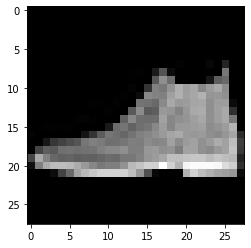

In [4]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 0, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
print(images.max())
#print(images)
print(invTrans(images))
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens: 5, 8, 9, 13, 16, 17, 18

In [5]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM, GradCAM, FullGrad, GradCAMPlusPlus, ScoreCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic, felzenszwalb, quickshift, watershed, flood
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel

In [11]:
def get_grayscale_grad_cam(image, SMU_class_index):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(SMU_class_index)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer2]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

def segmentation_info(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


# I want to get the average attribution score for each segment
def cam_processor_for_segments(grayscale_cam_output, segments_slic):
    
    
    
    list_unique_regions = np.unique(segments_slic)
    region_attr_score = []
    final_region_attr_score = []
    num_pixels_in_region_list = []
    
    for i in (list_unique_regions):
        row_counter = 0
        column_counter = 0
        region_attr_score = []
        num_pixels_in_region = 0
        for row in grayscale_cam_output:
            for cell in row:
                current_score = grayscale_cam_output[row_counter, column_counter]
                current_region = segments_slic[row_counter, column_counter]
                if current_region == i:
                    region_attr_score.append(current_score)
                    num_pixels_in_region += 1
                column_counter +=1
            row_counter += 1
            column_counter = 0
        avg_score = np.mean(region_attr_score)
        final_region_attr_score.append(avg_score)
        num_pixels_in_region_list.append(num_pixels_in_region)
    
    unique_region_info = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(final_region_attr_score[i-1])
        image_list.append(num_pixels_in_region_list[i-1])
        image_list.append(np.sum(num_pixels_in_region_list))
        unique_region_info.append(image_list)
    
    return(unique_region_info)


def get_feature_masks(image, attributions, segments_slic):
    segments_slic_1 = segments_slic
    features = []
    for i in attributions:
        feature = np.where(i==segments_slic_1, 1, 0)
        features.append(feature)
        
    return(features)


def attribution_ranker(cam_processor_for_segments_output, num_top_attr):
    ranked_images = sorted(cam_processor_for_segments_output, key=itemgetter(1), reverse=True)
    top_ranked_features = []
    for i in range(num_top_attr):
        top_ranked_features.append(ranked_images[i][0])
        
    return top_ranked_features



def image_rankings(get_image_versions):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(get_image_versions, key=itemgetter(3))
    
    return ranked_images

def blur_image_from_attribution(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-1)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map]
    mask = np.array(mask).squeeze()
    #mask = mask.transpose(1,2,0)
    #print(mask.shape)
    #print(image.squeeze().cpu().numpy().shape)
    
    
    out = np.where(mask==np.array([0]), image.squeeze().cpu().numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out
    out = out.unsqueeze(0)
    out = out.unsqueeze(0)
    #print(out.shape)
    
    return out


In [7]:
def segmentation_info_slic(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)

def segmentation_info_felzenszwalb(image, scale, sigma, min_size):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = felzenszwalb(img_np, scale=scale, sigma=sigma, min_size=min_size)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


def segmentation_info_quickshift(image, kernel_size, max_dist, ratio):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = quickshift(img_np, kernel_size, max_dist, ratio)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)

def segmentation_info_bass(segmentation_dir):
    #img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = quickshift(img_np, kernel_size, max_dist, ratio)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


def softmax_score(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    #image = good_img_transform(image)
    image = image
    logits = model(image).cpu()
    #print(logits)
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]

    return probs


    

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def region_explainability(image, top_n_start, model, SMU_class_index, threshold, top_n_stop):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask
    print(len(features_1))
    
    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1
    
    sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
    sm_idx1 = np.argmax(sm1)
    pred_class = sm1[sm_idx1]
    pred = pred_class
    
    best_score_other_class = 0
    
    previous_features = False
    powerset_list = list()
    start = perf_counter()
    while pred == pred_class:
    #while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]


        powerset_list = list(more_itertools.powerset(features_list))
        # print(type(features_list[-1]))
        if previous_features:
            powerset_list = np.array([list(ele) for ele in powerset_list if len(ele) != 0], dtype=object)
            for ele in powerset_list:
                for i, mask in enumerate(ele[:]):
                    if np.array_equal(mask, features_list[-1]):
                        ele = np.delete(mask, i, axis=0)
        else:
            powerset_list = [list(ele) for ele in powerset_list if len(ele) != 0]
        
        
        # print(len(powerset_list))
        
        num_versions = len(powerset_list)
        
    
        #print(image.shape)
        
        original_image = invTrans(image)
        
        #print(original_image.shape)
        
        # image_versions.append(original_image)
        # num_pixels_changed.append(0)
        # total_attr_list.append(np.zeros((28, 28)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((28, 28))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            #obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            # score = softmax_score(num_total_pixels = total_num_pixels,
            #                       num_obf_pixels = num_pixels_changed,
            #                       model = model,
            #                       image = obfuscated_image,
            #                       SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            # sm1 is softmax scores of original image, sm_idx1 is the index of top softmax score (the predicted class)
            # sm1[sm_idx1] gives the softmax score of the predicted class
            # sm2 is like sm1 but on an obfuscated image
            # sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
            # sm_idx1 = np.argmax(sm1)
            sm2 = softmax(model(obfuscated_image.to(device)).cpu().detach().numpy()).squeeze()
            sm_idx2 = np.argmax(sm2)
            
            if (sm_idx1 != sm_idx2) and sm2[sm_idx2] > best_score_other_class:
                best_score_other_class = sm2[sm_idx2] 
            
            if (sm_idx1 != sm_idx2) and (sm2[sm_idx2] > threshold):
                pred_class = sm_idx2
                image_versions.append(obfuscated_image)
                #sm2[sm_idx1] is the softmax score of the obfuscated image of the original class.
                #This score shows us how far the prediction has changed from the original image
                scores.append(sm2[sm_idx1])
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
            
#             if score < 0.5:
#                 prob = score
#                 image_versions.append(obfuscated_image)
#                 scores.append(score)
#                 num_pixels_changed.append(num_changes)
#                 total_attr_list.append(total_attribution)
                
#                 #print(score)
        
        print("Regions analyzed", top_n)
        top_n = top_n + 1
        if top_n == top_n_stop:
            end = perf_counter() - start
            print(f'Total Search time: {end:.3f}')
            return -1
        previous_features = True
    
    end = perf_counter() - start
    print(f'Total Search time: {end:.3f}')
    
    top_n = top_n - 1
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        image_list.append(avg_attr_scores)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

tensor([6])
tensor([6], device='cuda:0')


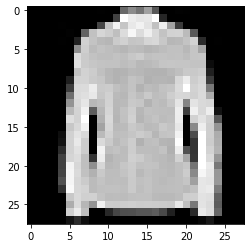

In [8]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 26, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens: 0, 

In [17]:
i = 0
n = 0
while i < 10:
    torch.manual_seed(0)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    #images, labels = next(itertools.islice(testloader, n, None))
    images, labels = next(itertools.islice(test_data, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    
    if just_label == 9 and predicted == 9:
        print('index:', n)
        i += 1
    
    n += 1

index: 7
index: 9
index: 12
index: 16
index: 20
index: 58
index: 62
index: 73
index: 78
index: 92


tensor([9])
tensor([9], device='cuda:0')


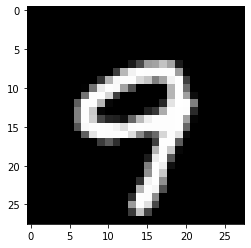

In [23]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 58, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens: 5, 8, 9, 13, 16, 17, 18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 6  6  6  6  6  6  2  2  2  2  2  2  3  3  3  3  3  3  7  7  7  7  7  8
   8  8  8  8]
 [ 6  6  6  6  6  6  9  9  9  9  9  9  3  3  3  3  3  7  7  7  7  7  7  8
   8  8  8  8]
 [ 6  6  6  6  6  6  9  9  9  9  9  9 10 10 10 10 10 10  7  7  7  7  7  8
   8  8  8  8]
 [ 6  6  6  6  6  6  9  9  9  9  9 10 10 10 10 10 10 10 10  7  7  7  7  8
   8  8  8  8]
 [ 6  6  6  6  6  9  9  9  9  9  9  9 11 11 11 11 10 10 10  7  7  7  7  8
   8  8  8  8]
 [ 6  6  6  6  6  9  

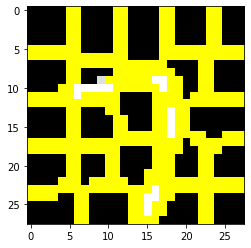

In [11]:
inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=25, compactness=1,
                     start_label=1)
print(segments_slic)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28)


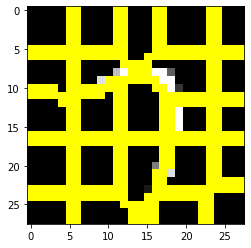

In [12]:
inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
print(img_np.shape)
segments_slic = watershed(img_np, markers=25, compactness=0.001)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


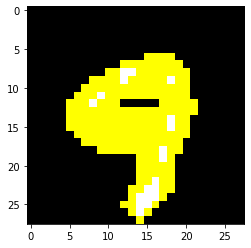

In [32]:
inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = felzenszwalb(img_np, scale=5, sigma=0.5, min_size=5)
#print(segments_slic)
print(len(np.unique(segments_slic)))
print(np.unique(segments_slic))
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

In [14]:
inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = quickshift(img_np, kernel_size=1, max_dist=6, ratio=0.5)
#print(segments_slic)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

ValueError: the input array must have size 3 along `channel_axis`, got (28, 28, 1)

In [28]:
def csv_mask_to_numpy(csv_path: str) -> np.ndarray:
    """Converts a csv_mask_file into a numpy arrays.
    
    Args:
        csv_mask_dir_path (str): The path to csv mask directory.
            Note, this should be the same as 'output_dir_path' from run_bass() function
        
    Returns:
        A list of np array masks.
    """
    # - 1 so that the superpixel values start at 0
    return np.loadtxt(csv_path, delimiter=",", dtype=int)

In [35]:
a = "test.png"
b = a[:-3] + 'csv'
print(b)

test.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


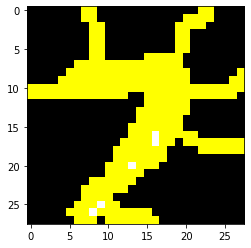

In [34]:
data_dir = "../labelme/MNIST_71/test_images"
img = Image.open(str(data_dir)+"/seven_170.png")
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # transforms.RandomAffine(20, translate=(0.20,0.20))
    ])
image_to_tensor = transform_test(img).unsqueeze(0)
img_np = image_to_tensor.detach().cpu().squeeze().numpy()
bass_seg = csv_mask_to_numpy("../labelme/MNIST_71/BASS_output/seven_170.csv")
plt.imshow(segmentation.mark_boundaries(img_np, bass_seg))

In [11]:
# working_example = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 1)

In [13]:
print(working_example[-2])
print(working_example[-1])
print(model(images.to(device)))
print(model(working_example[0].to(device)))
plt.imshow(working_example[0].detach().cpu().squeeze(), cmap='gray')

NameError: name 'working_example' is not defined

tensor([7])
tensor([7], device='cuda:0')


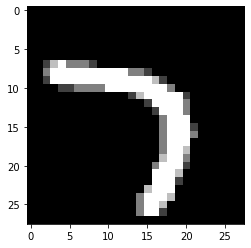

In [43]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 60, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens:index: 0, 17, 26, 34, 36, 41, 60, 64, 70, 75
# Good outputs 17, 48, 

In [50]:
input_tensor = images.to(device)
print(input_tensor.shape)
targets = [ClassifierOutputTarget(7)]
target_layers = [model.layer2]
print(targets)
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.min())
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

torch.Size([1, 1, 28, 28])


AttributeError: 'list' object has no attribute 'shape'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 339.08it/s]

0.0


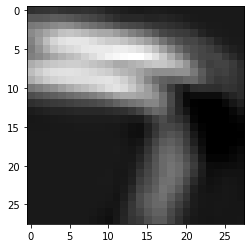

In [47]:
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(7)]
target_layers = [model.layer2]
cam = AblationCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.min())
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

25
Regions analyzed 1
Regions analyzed 2
Regions analyzed 3
Regions analyzed 4
Regions analyzed 5
Regions analyzed 6
Regions analyzed 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Regions analyzed 8
Total Search time: 0.319
regions analyzed 8
Original Version Predicted Class: 6    With Confidence: 0.7592856
Modified Version Predicted Class: 4    With Confidence: 0.9735357


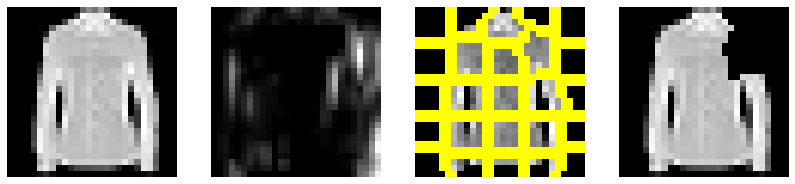

In [12]:
# Just give an images and it will output

input_tensor = images.to(device)
targets = [ClassifierOutputTarget(6)]
target_layers = [model.layer2]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=25, compactness=1,
                     start_label=1)

working_example = region_explainability(image = images, top_n_start = 1, 
                                        model = model, SMU_class_index = 6, 
                                        threshold = 0.8, top_n_stop = 21)
print("regions analyzed", working_example[-2])
sm1 = softmax(model(images.to(device)).cpu().detach().numpy()).squeeze()
sm_idx1 = np.argmax(sm1)
sm2 = softmax(model(working_example[0].to(device)).cpu().detach().numpy()).squeeze()
sm_idx2 = np.argmax(sm2)
print("Original Version Predicted Class:",sm_idx1, "   With Confidence:", sm1[sm_idx1])
print("Modified Version Predicted Class:",sm_idx2, "   With Confidence:", sm2[sm_idx2])
#print(sm2)

#print(model(images.to(device)))
#print(model(working_example[0].to(device)))


# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# ax1.imshow(images.detach().cpu().squeeze(), cmap='gray' )
# plt.axis('off')
# ax2.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)
# plt.axis('off')
# ax3.imshow(segmentation.mark_boundaries(img_np, segments_slic))
# plt.axis('off')
# ax4.imshow(working_example[0].detach().cpu().squeeze(), cmap='gray')
# plt.axis('off')

plot_images = (input_tensor.detach().cpu().squeeze(),
                  grayscale_cam,
                  segmentation.mark_boundaries(img_np, segments_slic),
                  working_example[0].detach().cpu().squeeze())
    
figure_name = plt.figure(figsize=(14, 14))
for i, img in enumerate(plot_images):
    plt.subplot(1, 4,i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.margins(x=0)

In [13]:
print(working_example[0])

tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -0.1686,  0.0902,
           -0.0902,  0.2549, -0.3098, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -0.4902,  1.0000,  0.8510,
            0.7961,  0.8118,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000,
           -1.0000, -1.0000, -0.4588,  0.5294,  0.9059,  0.5451,  0.8196,
            0.8980,  0.7882,  0.5137,  0.8667, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000,
           -0.2235,  0.5137,  0.678

In [26]:
print(segments_slic)

[[ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
   5  5  5  5]
 [ 6  6  6  6  6  6  7  7  7  7  7  7  3  3  3  3  3  8  8  8  8  8  8  9
   9  9  9  9]
 [ 6  6  6  6  6  6  7  7  7  7  7  7  7  3 10 10 10 10 10  8  8  8  8  9
   9  9  9  9]
 [ 6  6  6  6  6  6  7  7  7  7  7  7 10 10 10 10 10 10 10  8  8  8  8  9
   9  9  9  9]
 [ 6  6  6  6  6  6  7  7  7  7  7 10 10 10 10 10 10 10 10 10  8  8  8  9
   9  9  9  9]
 [ 6  6  6  6  6  6  7  7  7 11 11 11 10 12 12 12 12 10 10 13  8  8  8  9
   9  9  9  9]
 [ 6  6  6  6  6  6  

# Quantitative Experiments

## Experimenting with different clustering methods

In [ ]:
# # To test our algorithm with SLIC with 25 regions and 1 compactness
def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask

    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1
    
    sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
    sm_idx1 = np.argmax(sm1)
    pred_class = sm1[sm_idx1]
    pred = pred_class
    
    while pred == pred_class:
    #while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
        
        #print(image.shape)
        
        original_image = invTrans(image)
        
        #print(original_image.shape)
        
        # image_versions.append(original_image)
        # num_pixels_changed.append(0)
        # total_attr_list.append(np.zeros((28, 28)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((28, 28))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            #obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            # score = softmax_score(num_total_pixels = total_num_pixels,
            #                       num_obf_pixels = num_pixels_changed,
            #                       model = model,
            #                       image = obfuscated_image,
            #                       SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            # sm1 is softmax scores of original image, sm_idx1 is the index of top softmax score (the predicted class)
            # sm1[sm_idx1] gives the softmax score of the predicted class
            # sm2 is like sm1 but on an obfuscated image
            # sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
            # sm_idx1 = np.argmax(sm1)
            sm2 = softmax(model(obfuscated_image.to(device)).cpu().detach().numpy()).squeeze()
            sm_idx2 = np.argmax(sm2)
            if sm_idx1 != sm_idx2:
                pred_class = sm_idx2
                image_versions.append(obfuscated_image)
                #sm2[sm_idx1] is the softmax score of the obfuscated image of the original class.
                #This score shows us how far the prediction has changed from the original image
                scores.append(sm2[sm_idx1])
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
            
#             if score < 0.5:
#                 prob = score
#                 image_versions.append(obfuscated_image)
#                 scores.append(score)
#                 num_pixels_changed.append(num_changes)
#                 total_attr_list.append(total_attribution)
                
#                 #print(score)
        
        print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    top_n = top_n - 1
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        image_list.append(avg_attr_scores)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

In [ ]:
# # To test our algorithm with SLIC with 25 regions and 1 compactness
i = 0
n = 0
image_info_list = []
while i < 50:
    torch.manual_seed(0)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    #images, labels = next(itertools.islice(testloader, n, None))
    images, labels = next(itertools.islice(test_data, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    
    logits = model(images.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    # Change probs[int] to int = SMU class index
    probs_orig = probs[0]
    #print(probs)
    
    
    if just_label == 7 and predicted ==7:
        print('index:', i+1)
        i += 1
        
        re = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 7)
        
        
        image_info = []
        example = re[0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs_obf = probs[0]
        #print(probs)
        image_info.append(probs_orig)
        image_info.append(probs_obf)
        
        num_pixels_obf = re[1]
        image_info.append(num_pixels_obf)
        image_info.append(re[5])
        sm1 = softmax(model(example.to(device)).cpu().detach().numpy()).squeeze()
        sm_idx1 = np.argmax(sm1)
        #sm_idx1 is the predicted class of the obfuscated image
        image_info.append(sm_idx1)
        
        image_info_list.append(image_info)
    n += 1

In [ ]:
success = 0
total = len(image_info_list)
total_pix = total * 28 * 28
total_obf = 0
total_orig_conf = 0
total_obf_conf = 0
total_regions = 0
preds_on_images = []
for i in range(len(image_info_list)):
    total_orig_conf += image_info_list[i][0]
    total_obf_conf += image_info_list[i][1]
    total_obf += image_info_list[i][2]
    total_regions += image_info_list[i][3]
    preds_on_images.append(image_info_list[i][4])


array_np = np.array(preds_on_images)
unique, counts = np.unique(array_np, return_counts=True)
#print(dict(zip(unique, counts)))

print("Experiment with SLIC with 25 segments and 1 compactness")
print("Average number of regions analyzed: ", total_regions / total)
print("Average confidence change: ", ((total_orig_conf - total_obf_conf) / total) )
print("Distribution of changed to class: ", dict(zip(unique, counts)))
print("Average obfuscation: ",total_obf / total_pix)

In [ ]:
# # To test our algorithm with felz with 25 regions and 1 compactness
def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask

    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1

    while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
        
        #print(image.shape)
        
        original_image = invTrans(image)
        
        #print(original_image.shape)
        
        # image_versions.append(original_image)
        # num_pixels_changed.append(0)
        # total_attr_list.append(np.zeros((28, 28)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((28, 28))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            #obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            score = softmax_score(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed,
                                  model = model,
                                  image = obfuscated_image,
                                  SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            if score < 0.5:
                prob = score
                image_versions.append(obfuscated_image)
                scores.append(score)
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
                
                #print(score)
        
        print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image